In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from skew_correction.data import DatasetClass, MyDataModule, plot_random_images
from skew_correction.model import MyModelModule, TimmClassifier, total_params
from skew_correction.constants import root_dir
from skew_correction.train_utils import checkpoint_callback, early_stop_callback

import os
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime
from pytz import timezone  # This library helps you get the timezone if needed

## data

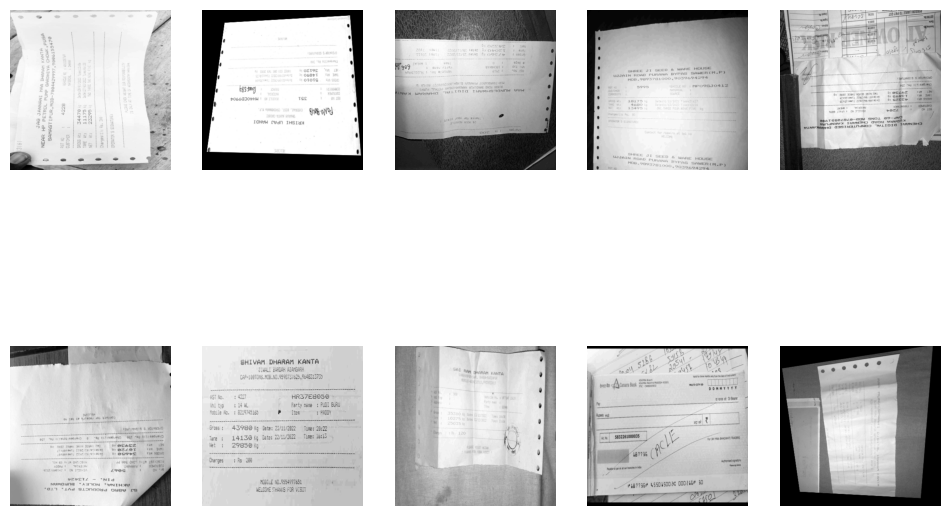

In [8]:
## load dataset
dataset = DatasetClass("/home/deepam_minda_farmart_co/fmt/skew_correction/data/train_data.csv", split='train')
plot_random_images(dataset)
pl_data = MyDataModule(dataset, train_bs=8, val_bs=8)

In [9]:
## check data sizes
pl_data.setup()
tdl = pl_data.train_dataloader()
vdl = pl_data.val_dataloader()
print(f"len of dataloader = {len(tdl)}, batchsize = {tdl.batch_size} \ntotal samples = {len(tdl)*tdl.batch_size}")
print(f"len of dataloader = {len(vdl)}, batchsize = {vdl.batch_size} \ntotal samples = {len(vdl)*vdl.batch_size}")

len of dataloader = 44, batchsize = 8 
total samples = 352
len of dataloader = 11, batchsize = 8 
total samples = 88


## train


In [10]:
## load model

lr = 0.0003
loss_fn = torch.nn.CrossEntropyLoss()

model_string = 'resnet18'
dropout=0.3
model = TimmClassifier(model_string, dropout=dropout)
print(f"total_params: {total_params(model)}")

pl_model = MyModelModule(model, loss_fn, lr)


total_params: 11172292


In [11]:
verbose=False

# Get the current date and time in a specific format
current_date = datetime.now(timezone('Asia/Kolkata')).strftime('%Y-%m-%d')

tb_logger = TensorBoardLogger(
    save_dir=os.path.join(root_dir, 'logs'), 
    name=f"{current_date}-{model_string}-{len(tdl)*tdl.batch_size}samples-lr{lr}-bs{tdl.batch_size}-cpu-drop{dropout}"
)

trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=50, 
        logger=tb_logger, 
        log_every_n_steps=1, 
        limit_train_batches=None, 
        limit_val_batches=None,
        enable_checkpointing=True,
        callbacks=[checkpoint_callback, early_stop_callback],
    )


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(pl_model, datamodule=pl_data)

# pl_model.trainer.callback_metrics

Missing logger folder: /home/deepam_minda_farmart_co/fmt/skew_correction/logs/2023-07-31-resnet18-352samples-lr0.0003-bs8-cpu-drop0.3

  | Name    | Type             | Params
---------------------------------------------
0 | model   | TimmClassifier   | 11.2 M
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]==========> Epoch 0
{'val_loss': tensor(1.4120), 'val_acc': tensor(0.1875), 'val_acc_epoch': tensor(0.1875)}
Epoch 0: 100%|██████████| 55/55 [03:48<00:00,  4.15s/it, loss=1.28, v_num=0]==========> Epoch 0
{'train_loss': tensor(1.1703), 'train_acc': tensor(0.7143), 'train_acc_step': tensor(0.7143), 'val_loss': tensor(1.2498), 'val_acc': tensor(0.3977), 'val_acc_epoch': tensor(0.3977)}
Epoch 1: 100%|██████████| 55/55 [07:24<00:00,  8.08s/it, loss=0.987, v_num=0] ==========> Epoch 1
{
    "train_loss": 0.84,
    "train_acc_epoch": 0.33,
    "val_loss": 0.95,
    "val_acc_epoch": 0.45
}
Epoch 2: 100%|██████████| 55/55 [11:04<00:00, 12.07s/it, loss=0.774, v_num=0]  ==========> Epoch 2
{
    "train_loss": 0.69,
    "train_acc_epoch": 0.59,
    "val_loss": 0.81,
    "val_acc_epoch": 0.48
}
Epoch 3: 100%|██████████| 55/55 [14:45<00:00, 16.09s/it, loss=0.667, v_num=0]   ==========> Epoch 3
{
    "train_loss": 0.56,
    "